## Subhourly Solar Fleet Profiles using NREL NSRDB and pvlib python
_Will Hobbs, SCS R&D, 2024-05-02_ 

# Setup 

This document is based on a Jupyter Notebook, which is an interactive way to run Python code and to document it with markdown text and images. It should be shared as a .ipynb ("Interactive Python Notebook") file and a .pdf file - the .pdf is included to make it easier to get started. We will use Microsoft Visual Studio Code, a.k.a. VS Code, as a code editor or "IDE" (integrated development environment) for viewing, running, and editing the .ipynb file, but first we need to get it installed and setup. 

### Install VS Code
Install the standard Windows version of Visual Studio Code from https://code.visualstudio.com/download.

<img src="images/vs_code_installer2.png" width="500"/>

### Install Miniforge 

Miniforge makes it easy to install Python and Python packages. It's also possible to install Python directly and then use a native Python tool called `pip`, but `pip` doesn't work for everything without manual tweaking. Miniforge lets us use a tool called `conda` in addition to `pip`. (_See [1] of you are interested in a related discussion._)

Install miniforge3 from https://github.com/conda-forge/miniforge?tab=readme-ov-file#miniforge3.

Installer options that worked for me:
 - Install for: "Just Me"
 - Choose Install Location, Destination folder: default, e.g., C:\Users\whobbs\AppData\Local\miniforge3 or C:\Users\willh\miniforge3)
 - Advanced installation options, select all of:
   - "Create start menu shortcuts"
   - "Register Miniforge3 as my dafult Python 3.X"
   - "Clear the package cache upon completion"

### Install Python packages 

We will use `conda` to create a Python "environment", then activate that environment and install packages like `pvlib` and `herbie-data`. Environments can get complicatde, but the simple explanation is that they help keep things organized and make sure that packages you install for different projects don't conflict with eachother. 

Run the Miniforge Prompt Windows application that gets installed (go to Start, search "Miniforge Prompt"), and enter the following commands:

``` 
conda create --name pvlib_env python=3.11 -y
conda activate pvlib_env
pip install pvlib ipykernel jupyter cartopy openpyxl
ipython kernel install --user --name=pvlib_env

```

[1] https://github.com/pvlib/pvlib-python/discussions/1874

---

### Setup VS Code for our new environment

If VS Code is open, restart the program by closing it and opening it again. 

<!-- <span style="color:red">**If you are reading this document as a .pdf, open the .ipynb (Jupyter Notebook) file in VS Code and switch over to that version to continue.**</span> -->

<!-- If VS code prompts you about the file being untrusted, select "Open":

<img src="images/untrusted_file.png" width="500"/> -->

We need to pick the Python "kernel" to use, and in our case, it will be one inside the environment we created earlier. In the top right, click "Select Kernel". If you see the option to install Python and/or Jupyter extensions, click to install them.

<img src="images/vscode_extensions.png" width="500"/>

Click "Select Kernel" again and then click "Python Environments..." from the menu that drops down:

<img src="images/select_env_1.png" width="500"/>

Look for the environment name we created, `pvlib_env` and click it. If you don't see it listed, go to the next step.

<!-- <img src="images/select_env_2.png" width="500"/> -->

If the environment is not listed:
 1. Restart VS Code and repeat the above steps again. 
 2. If it still does not work:
    - Hit "Ctrl-Shift-P" to open the command pallet
    - type "interpreter" and select  "Python: Select Interpreter"

    <img src="images/interpreter.png" width="500"/>
    
    - Then "Find..." and browse to `C:\Users\[username]\AppData\Local\miniforge3\envs\pvlib_env`, where `[username]` is your user name, e.g., `C:\Users\whobbs\AppData\Local\miniforge3\envs\pvlib_env`, and select the "python.exe" file.

    <img src="images/interpreter2.png" width="500"/>
    
    <img src="images/interpreter3.png" width="500"/>

You should now see the environment name "pvlib_env" in the top right or the VS Code window. 

---

### NSRDB Data

We will use satellite-based irradiance data from the NREL National Solar Radiation Database (NSRDB) [1] web API, described here [2].

Downloading NSRDB data requires an API key. You can get one for free by signing up at https://developer.nrel.gov/signup/. 

Once you have a key, create a new file in a text editor (like Notepad), add your email address to the first line of the file and the API key to the second line of the file, and save the file `nrel_api_key_details.txt` in the folder `credentials`. For example:

<img src="images/api_key_sample_screenshot.png" width="500"/>

Alternatively, you can hardcode your API credentials into the code in this notebook, but then you cannot share the code without modifying it or disclosing your credentials. 

[1] https://nsrdb.nrel.gov/

[2] https://developer.nrel.gov/docs/solar/nsrdb/psm3-2-2-download/ 

---

### Corporate Firewall issues

Some corporate firewalls modify web server certificates, which can cause SSL errors when downloading NSRD data. You might ask your IT department to whitelise mapfiles.nrel.gov (port 443) and gds-files.nrelcloud.org (port 443), which _should_ fix the issue. 

If you get SSL errors, one solution is to navigate to each of the URLs above in a web browser on your corporate network and manually export the certificates. Open the certificate files (.pem or .crt) in a text editor, copy the full contents of the file into another text file, and save it as `merged_certificates.pem` (without .txt on the end) in the same folder as this script. Code below will look for that file if an SSL error occurs.

Here's what that merged certificate text should look like:

```
-----BEGIN CERTIFICATE-----
lkjwefkjsdlkfh132847193rhkj1dhksdlkjKJAHKJHASKDjhakshfkAJHSDfqwe
KJHKJHfdskjahLKDfuiewyriuy92387rE9823r98ueoiJLKhkjhkJHKHJY329841
kjdlkfOIWfkj hawiufwaiueyr982347rwoiefjlksajdfoiw02j0e9djdsfjclk
```
[middle of the first certificate left out]
```
LKJSAFl kjdskfjkldskjfa lksjdflkwoeiou2r9238r92038r92308asdjkjas
skjdhfaiouei7+=
-----END CERTIFICATE-----
-----BEGIN CERTIFICATE-----
dskgjli3q4798urfoijwqeoifjoisjoiJOIHOIUF98sufoisuf98suef9p8w7r98
i73q948ruq3iefjkejfoiwuf098w7f2987r9384uroi3jflkjdf/lksjdflkjasl
```
[middle of the second certificate left out]
```
wealrcq'3rcu3iDpo3\3ercoi3uroi324r7oiweur92ueoijsdlkjUOI19289872
a lkju28397+lkafdk
-----END CERTIFICATE-----
```
---

### PV performance model

<img src="images/pvlib_powered_logo_horiz.png" width="300"/>

We will use pvlib (a.k.a. pvlib-python) [1] for modeling the solar plants and for fetching NSRDB data. There are many possible workflows for modeling solar plants with pvlib. We will use:
 - Perez transposition model
 - Faiman temperature model with the Prilliman et al. transient temperature model adjustment
 - PVWatts DC power model, with a simple linear loss factor applied
 - PVWatts inverter model

Items _not_ currently accounted for include:
 - Row-to-row self-shade losses
 - Bifacial PV modules
 - Module degradation and/or plant performance loss rate over time

Self-shade and bifacial could be accounted for using concepts in https://github.com/williamhobbs/2024_pvpmc_self_shade. 

[1] Anderson, K., Hansen, C., Holmgren, W., Jensen, A., Mikofski, M., and Driesse, A. “pvlib python: 2023 project update.” Journal of Open Source Software, 8(92), 5994, (2023). https://doi.org/10.21105/joss.05994

---

In [1]:
import pvlib
import pickle
import pandas as pd
import os
import requests
from pathlib import Path
import hashlib

import time 

import matplotlib.pyplot as plt
# import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature

### Import list of plants with specifications

This list is based on EIA Form 860 data [1]. I pulled the list of solar plants (`3_3_Solar_Y2022_Early_Release.xlsx`), used Excel `xlookup()` to merge latitude, longitude from full plant list (`2___Plant_Y2022_Early_Release.xlsx`), filtered on Balancing Authority Code = "SOCO", sorted by AC capacity, and excluded sites in Florida.

I made the following metadata assumptions:
 - `temperature_coefficient`: if crystalline, -0.35 %/deg C, if thin film, -0.25 %/deg C
 - `axis_tilt`, `axis_azimuth`, `rotation_angle`: if `tracking_type` is `single_axis`, 0, 180, 60, respectively
 - `backtracking`: if `single_axis` and crystalline, `True`, else, `False`
 - `ground_coverage_ratio`: `fixed` - 0.5; `single_axis` with thin film - 0.45; `single_axis` with crystalline - 0.35

Results were saved as a .csv as `pv_fleet_metadata_rev3b.csv`.

 [1] https://www.eia.gov/electricity/data/eia860/


In [2]:
plants_df = pd.read_csv('pv_fleet_metadata_rev3b.csv') # read in as a Pandas DataFrame
plants_df = plants_df[plants_df['power_plant_ac_max']>=5].copy().reset_index()
num_plants = len(plants_df.index) # number of plants
print('number of plants: ' + str(num_plants))
print('total namesplate (MWac): ' + str(plants_df.power_plant_ac_max.sum()))
plants_df.head() # preview the DataFrame

number of plants: 54
total namesplate (MWac): 3737.9


,index,plant_name,plant_code,latitude,longitude,power_plant_ac_max,dc_capacity_plant,dc_loss_factor,temperature_coefficient,gamma_pdc,...,fixed_azimuth,axis_tilt,axis_azimuth,backtrack,max_tracker_angle,gcr,Crystalline Silicon?,Thin-Film (CdTe)?,Operating_Month,Operating_Year
0,0,Cool Springs Solar (Hybrid),63721.0,30.747916,-84.680492,213.0,298.0,0.15,-0.35,-0.0035,...,180,0.0,180.0,True,60.0,0.35,Y,NaN,12.0,2021.0
1,1,Twiggs Solar,61696.0,32.604997,-83.491239,204.0,261.0,0.15,-0.25,-0.0025,...,0,0.0,180.0,False,60.0,0.45,NaN,Y,9.0,2020.0
2,2,Hickory Park Solar Hybrid,63522.0,31.269676,-84.176321,195.5,268.8,0.15,-0.35,-0.0035,...,,0.0,180.0,True,60.0,0.35,Y,NaN,6.0,2022.0
3,3,Camilla Solar Energy Project,61785.0,31.269550,-84.228721,171.4,224.0,0.15,-0.35,-0.0035,...,0,0.0,180.0,True,60.0,0.35,Y,NaN,2.0,2020.0
4,4,"SR DeSoto I, LLC",64841.0,31.886486,-84.021586,165.0,177.4,0.15,-0.25,-0.0025,...,180,0.0,180.0,False,60.0,0.45,NaN,Y,12.0,2022.0


Use cartopy to make a map of the sites, with marker size mapped to AC nameplate:

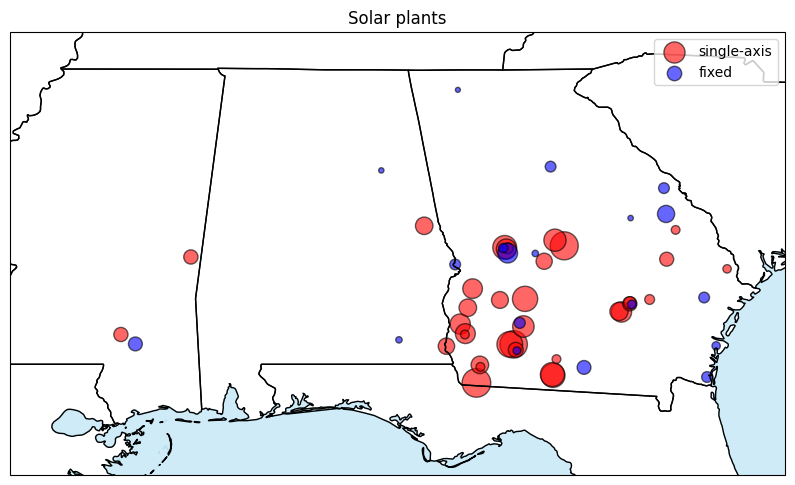

In [3]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# ax.add_feature(cfeature.LAND, color="lightgrey", alpha=0.5)
ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-91, -80.5, 29.5, 35.5],
              crs=crs.PlateCarree()) ## Important


plt.scatter(x=plants_df[plants_df['mount_type']=='single-axis']['longitude'],
            y=plants_df[plants_df['mount_type']=='single-axis']['latitude'],
            color="red",
            edgecolors='black',
            s=plants_df[plants_df['mount_type']=='single-axis']['power_plant_ac_max']*2,
            alpha=0.6,
            transform=crs.PlateCarree()) ## Important

plt.scatter(x=plants_df[plants_df['mount_type']=='fixed']['longitude'],
            y=plants_df[plants_df['mount_type']=='fixed']['latitude'],
            color="blue",
            edgecolors='black',
            s=plants_df[plants_df['mount_type']=='fixed']['power_plant_ac_max']*2,
            alpha=0.6,
            transform=crs.PlateCarree()) ## Important

plt.legend(['single-axis', 'fixed'])
plt.title('Solar plants')
plt.show()

For our first examples, let's just use the first 3 sites so things go more quickly. 

In [4]:
plants_df = plants_df.head(3)
num_plants = len(plants_df.index) # number of plants

### Irradiance data

Now let's get some irradiance data from the NREL NSRDB [1] using `pvlib` [2]. The NSRDB requires an API key from the NREL Developer Network [3]. We will use the `pvlib.iotools.get_psm3` function - details are here https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_psm3.html.

We will download the NSRDB data and metadata once and then store it in pickle files, so the next time we run it we can simply open the pickle file. If the list of plants changes after running the first time, you will need to delete the pickle files and run this again. 

*Note: For about 50 plants, this takes about 10 minutes to run, and results in a ~500 GB pickle file. I'm not sure how much the download time is limited by my internet connection (~300 Mb/s) or NREL servers.* 

[1] https://nsrdb.nrel.gov/.

[2] Anderson, K., Hansen, C., Holmgren, W., Jensen, A., Mikofski, M., and Driesse, A. “pvlib python: 2023 project update.” Journal of Open Source Software, 8(92), 5994, (2023). https://doi.org/10.21105/joss.05994

[3] https://developer.nrel.gov/signup/

First, read in your API key details:

In [5]:
## API key credentials are stored in a separate text file
try:
    with open('credentials/nrel_api_key_details.txt') as f: # full path and filename of text file with email on first line and api key on second line
        email = f.readline().rstrip()  # rstrip removes trailing line breaks and spaces
        nrel_api_key = f.readline().rstrip()
except:
    print('error with email and API key, using temporary defaults')
    print('register at https://developer.nrel.gov/')
    print('create the folder and text file referenced above with email on first line and API key on second line')
    nrel_api_key = 'DEMO_KEY'
    email = 'your_email@domain.com'

Then get the data. You can change the `year` value to any valid year with 5-min data. See the valid valies for the `names` parameter here https://developer.nrel.gov/docs/solar/nsrdb/psm3-5min-download/ for the latest availability. 

The code below first checks to see if you have already downloaded the data and saved it in a "pickle" file. If you have not, it will download the data and then save it in a pickle file for use later. The pickle files are given unique names with a hash based on the list of latitude and longitude values. If that list changes, either by adding, removing, re-ordering, or modifying (e.g., rounding) any of the values, a new hash will be created and a new file will be downloaded. 

In [6]:
year = 2022
interval = 5

nsrdb_data_dict = {}
nsrdb_metadata_dict = {}

# hash for unique set of lat, lon values
hash_str = hashlib.sha1(pd.util.hash_pandas_object(plants_df[['latitude','longitude']],
                                                   index=True).values).hexdigest()
data_folder = 'nsrdb_data/'
data_filename = 'nsrdb_data_dict_pickle_' + str(year) + '_' + str(interval) + 'min_' + hash_str + '.pickle'
metadata_filename = 'nsrdb_metadata_dict_pickle_' + str(year) + '_' + str(interval) + 'min.pickle'

attributes = ['air_temperature',
              'clearsky_dhi',
              'clearsky_dni',
              'clearsky_ghi',
              'cloud_type',
              'dhi',
              'dni',
              'ghi',
              'surface_albedo',
              'wind_speed',
            #   'dew_point',
            #   'fill_flag',
            #   'relative_humidity',
            #   'solar_zenith_angle', 
            #   'surface_pressure',
            #   'total_precipitable_water',
            #   'wind_direction',
              ]
try: # try to load dictionaries from existing pickle files
    pickle_in = open(data_folder + data_filename, 'rb')
    nsrdb_data_dict = pickle.load(pickle_in)
    pickle_in = open(data_folder + metadata_filename, 'rb')
    nsrdb_metadata_dict = pickle.load(pickle_in)
    pickle_in.close()
    print('loaded NSRDB data from pickle file')
except: # if the pickle files don't exist, get NSRDB data, store in dictionaries, save as pickle files   
    try: # try connecting to the NSRDB API
        os.environ['REQUESTS_CA_BUNDLE'] = ''
        r = requests.get(('https://developer.nrel.gov/api/nsrdb/v2/solar/'
                              'psm3-2-2-download.csv?api_key=' + nrel_api_key + '&'
                              'email=' + email + '&'
                              'wkt=POINT(-108.5449+40.5137)&names=2021'))
        del r
        print('connection worked')
    except: # if that didn't work, use a local copy of the certificate
        print('connection issue, assumed to be an SSL error, using local certificate')
        current_directory = Path().absolute()
        # full path to certificate pem file
        cert_path = os.path.join(current_directory, 'merged_certificates.pem') 
        os.environ['REQUESTS_CA_BUNDLE'] = cert_path
        r = requests.get(('https://developer.nrel.gov/api/nsrdb/v2/solar/'
                              'psm3-2-2-download.csv?api_key=' + nrel_api_key + '&'
                              'email=' + email + '&'
                              'wkt=POINT(-108.5449+40.5137)&names=2021'))
    for x in range(0,num_plants):
    # for x in range(0,5):
        lat = plants_df.iloc[x]['latitude'] 
        lon = plants_df.iloc[x]['longitude']
        print('getting site number: ' + str(x+1))
        try:
            nsrdb_data_dict[x], nsrdb_metadata_dict[x] = pvlib.iotools.get_psm3(latitude=lat,
                                                    longitude=lon,
                                                    api_key=nrel_api_key,
                                                    email=email,
                                                    names=year,
                                                    interval=interval,
                                                    leap_day=True,
                                                    map_variables=True,
                                                    attributes=attributes
                                                    )
        except:
            time.sleep(10) # pause for 10 sec before trying again
            nsrdb_data_dict[x], nsrdb_metadata_dict[x] = pvlib.iotools.get_psm3(latitude=lat,
                                                    longitude=lon,
                                                    api_key=nrel_api_key,
                                                    email=email,
                                                    names=year,
                                                    interval=interval,
                                                    leap_day=True,
                                                    map_variables=True,
                                                    attributes=attributes
                                                    )

        # convert to UTC
        nsrdb_data_dict[x].index = nsrdb_data_dict[x].index.tz_convert('UTC')
        
        # adjust metadata to match
        nsrdb_metadata_dict[x]['Time Zone'] = 0

    # save dictionaries as pickle files
    pickle_out = open(data_filename, 'wb')
    pickle.dump(nsrdb_data_dict, pickle_out)
    pickle_out.close()

    pickle_out = open(metadata_filename, 'wb')
    pickle.dump(nsrdb_metadata_dict, pickle_out)
    pickle_out.close()

loaded NSRDB data from pickle file


### Solar position

Calculate solar position with `pvlib`. We could also calculate clear sky irradiance with `pvlib` (https://pvlib-python.readthedocs.io/en/stable/reference/clearsky.html), but we got that from the NSRDB in the last step.

In [7]:
# clear_sky_dict = {} # <-- uncomment to calculate clear sky with pvlib
solar_position_dict = {}
for x in range(0,num_plants):
    lat = plants_df.iloc[x]['latitude'] 
    lon = plants_df.iloc[x]['longitude']
    times = nsrdb_data_dict[x].index 
    loc = pvlib.location.Location(latitude=lat, longitude=lon, tz=times.tz)
    solar_position_dict[x] = loc.get_solarposition(times)
    # clear_sky_dict[x] = loc.get_clearsky(times) # <-- uncomment to calculate clear sky with pvlib

### Power data

Let's use the NSRDB data to calculate ac power for each plant using the PVWatts model in `pvlib`.

In [8]:
transposition_model = 'perez-driesse'
eta_inv_nom = 0.98

surface_tilt = {}
surface_azimuth = {}
total_irradiance = {}
power_ac = {}
for x in range(0,num_plants):
    # surface tilt and azimuth
    if plants_df['mount_type'][x] == 'single-axis':  
        # tracker orientation angles
        singleaxis_kwargs = dict(apparent_zenith=solar_position_dict[x].apparent_zenith,
                                 apparent_azimuth=solar_position_dict[x].azimuth,
                                 axis_tilt=plants_df['axis_tilt'][x],
                                 axis_azimuth=plants_df['axis_azimuth'][x],
                                 backtrack=plants_df['backtrack'][x],
                                 gcr=plants_df['gcr'][x],
                                 )
        orientation = pvlib.tracking.singleaxis(max_angle=plants_df['max_tracker_angle'][x],
                                                **singleaxis_kwargs)
        surface_tilt[x] = orientation.surface_tilt.fillna(0)
        surface_azimuth[x] = orientation.surface_azimuth.fillna(0)
    elif plants_df['mount_type'][x] == 'fixed':
        surface_tilt[x] = float(plants_df['fixed_tilt'][x])
        surface_azimuth[x] = float(plants_df['fixed_azimuth'][x])

    # dni and airmass
    dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_dict[x].index)
    airmass = pvlib.atmosphere.get_relative_airmass(
        solar_position_dict[x].apparent_zenith,
        model='kastenyoung1989'
    )

    # Transposed components of POA
    total_irradiance[x] = pvlib.irradiance.get_total_irradiance(
        surface_tilt[x], 
        surface_azimuth[x],
        solar_position_dict[x].apparent_zenith, 
        solar_position_dict[x].azimuth, 
        nsrdb_data_dict[x].dni, 
        nsrdb_data_dict[x].ghi, 
        nsrdb_data_dict[x].dhi, 
        airmass=airmass,
        albedo=nsrdb_data_dict[x].albedo, 
        dni_extra=dni_extra, 
        model=transposition_model
    )

    # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
    t_cell = pvlib.temperature.faiman(total_irradiance[x].poa_global,
                                      nsrdb_data_dict[x].temp_air,
                                      nsrdb_data_dict[x].wind_speed,
    )

    # transient cell temperature, since we are working with intervals shorter than 20 minutes
    t_cell = pvlib.temperature.prilliman(t_cell, nsrdb_data_dict[x].wind_speed)

    # PVWatts dc power
    pdc = pvlib.pvsystem.pvwatts_dc(total_irradiance[x].poa_global,
                                    t_cell,
                                    plants_df['dc_capacity_plant'][x],
                                    plants_df['gamma_pdc'][x])
    # inverter dc input is ac nameplate divided by nominal inverter efficiency
    pdc0 = plants_df['power_plant_ac_max'][x]/eta_inv_nom 
    # dc power into the inverter is modeled pdc after losses
    pdc_inv = pdc*(1-plants_df['dc_loss_factor'][x]) 

    # PVWatts ac power
    power_ac[x] = pvlib.inverter.pvwatts(pdc_inv, pdc0, eta_inv_nom)

### Clear sky power

Now, let's model clear sky power. This could be useful if we want to normalized to a site- and design-specific clear sky profile.

We will use actual air temperature and wind speed, as there is no clear definition of "clear sky" temperature and wind speed. We could use something like https://rdtools.readthedocs.io/en/stable/generated/rdtools.clearsky_temperature.get_clearsky_tamb.html if we wanted more generic values.

In [9]:
transposition_model = 'perez-driesse'
eta_inv_nom = 0.98

surface_tilt = {}
surface_azimuth = {}
total_irradiance_cs = {}
power_ac_cs = {}
for x in range(0,num_plants):
    # surface tilt and azimuth
    if plants_df['mount_type'][x] == 'single-axis':  
        # tracker orientation angles
        singleaxis_kwargs = dict(apparent_zenith=solar_position_dict[x].apparent_zenith,
                                 apparent_azimuth=solar_position_dict[x].azimuth,
                                 axis_tilt=plants_df['axis_tilt'][x],
                                 axis_azimuth=plants_df['axis_azimuth'][x],
                                 backtrack=plants_df['backtrack'][x],
                                 gcr=plants_df['gcr'][x],
                                 )
        orientation = pvlib.tracking.singleaxis(max_angle=plants_df['max_tracker_angle'][x],
                                                **singleaxis_kwargs)
        surface_tilt[x] = orientation.surface_tilt.fillna(0)
        surface_azimuth[x] = orientation.surface_azimuth.fillna(0)
    elif plants_df['mount_type'][x] == 'fixed':
        surface_tilt[x] = float(plants_df['fixed_tilt'][x])
        surface_azimuth[x] = float(plants_df['fixed_azimuth'][x])

    # dni and airmass
    dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_dict[x].index)
    airmass = pvlib.atmosphere.get_relative_airmass(
        solar_position_dict[x].apparent_zenith,
        model='kastenyoung1989'
    )

    # Transposed components of POA
    total_irradiance_cs[x] = pvlib.irradiance.get_total_irradiance(
        surface_tilt[x], 
        surface_azimuth[x],
        solar_position_dict[x].apparent_zenith, 
        solar_position_dict[x].azimuth, 
        nsrdb_data_dict[x].dni_clear, 
        nsrdb_data_dict[x].ghi_clear, 
        nsrdb_data_dict[x].dhi_clear, 
        airmass=airmass,
        albedo=nsrdb_data_dict[x].albedo,
        dni_extra=dni_extra, 
        model=transposition_model
    )

    # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
    t_cell = pvlib.temperature.faiman(total_irradiance_cs[x].poa_global,
                                      nsrdb_data_dict[x].temp_air,
                                      nsrdb_data_dict[x].wind_speed,
    )

    # transient cell temperature, since we are working with intervals shorter than 20 minutes
    t_cell = pvlib.temperature.prilliman(t_cell, nsrdb_data_dict[x].wind_speed)

    # PVWatts dc power
    pdc = pvlib.pvsystem.pvwatts_dc(total_irradiance_cs[x].poa_global,
                                    t_cell,
                                    plants_df['dc_capacity_plant'][x],
                                    plants_df['gamma_pdc'][x])
    # inverter dc input is ac nameplate divided by nominal inverter efficiency
    pdc0 = plants_df['power_plant_ac_max'][x]/eta_inv_nom 
    # dc power into the inverter is modeled pdc after losses
    pdc_inv = pdc*(1-plants_df['dc_loss_factor'][x]) 

    # PVWatts ac power
    power_ac_cs[x] = pvlib.inverter.pvwatts(pdc_inv, pdc0, eta_inv_nom)
    

Now let's sum the NSRDB-modeled power for each plant into a single series:

max power: power_ac    612.5
dtype: float64


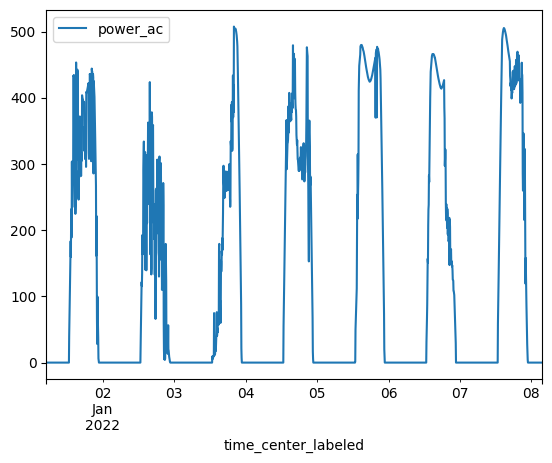

In [10]:
power_ac_nsrdb_all = pd.concat(power_ac, axis=1, sort=False).sum(axis=1)
power_ac_nsrdb_all = power_ac_nsrdb_all.to_frame(name='power_ac')
power_ac_nsrdb_all.index.names = ['time_center_labeled']
print('max power: ' + str(power_ac_nsrdb_all.max()))
power_ac_nsrdb_all[0:2000].plot()
plt.show()

And the same for clear sky power:

In [11]:
power_ac_clearsky_all = pd.concat(power_ac_cs, axis=1, sort=False).sum(axis=1)
power_ac_clearsky_all = power_ac_clearsky_all.to_frame(name='power_ac')
power_ac_clearsky_all.index.names = ['time_center_labeled']
print('max power: ' + str(power_ac_clearsky_all.max()))

max power: power_ac    612.5
dtype: float64


### Running it multiple times
Now, put it all in a few functions that we can run more easily:
 - `get_nsrdb_data()` will download/load NSRDB data
 - `make_profiles()` will make actual and clear sky power profiles. 
 - `make_map()` makes map plots. 

In [12]:
def get_nsrdb_data(plants_df, email, nrel_api_key, year=2022, interval=5):
    num_plants = len(plants_df.index) # number of plants

    nsrdb_data_dict = {}
    nsrdb_metadata_dict = {}

    # hash for unique set of lat, lon values
    hash_str = hashlib.sha1(pd.util.hash_pandas_object(plants_df[['latitude','longitude']],
                                                    index=True).values).hexdigest()
    data_folder = 'nsrdb_data/'
    data_filename = 'nsrdb_data_dict_pickle_' + str(year) + '_' + str(interval) + 'min_' + hash_str + '.pickle'
    metadata_filename = 'nsrdb_metadata_dict_pickle_' + str(year) + '_' + str(interval) + 'min.pickle'

    attributes = ['air_temperature',
                'clearsky_dhi',
                'clearsky_dni',
                'clearsky_ghi',
                'cloud_type',
                'dhi',
                'dni',
                'ghi',
                'surface_albedo',
                'wind_speed',
                #   'dew_point',
                #   'fill_flag',
                #   'relative_humidity',
                #   'solar_zenith_angle', 
                #   'surface_pressure',
                #   'total_precipitable_water',
                #   'wind_direction',
                ]
    try: # try to load dictionaries from existing pickle files
        pickle_in = open(data_folder + data_filename, 'rb')
        nsrdb_data_dict = pickle.load(pickle_in)
        pickle_in = open(data_folder + metadata_filename, 'rb')
        nsrdb_metadata_dict = pickle.load(pickle_in)
        pickle_in.close()
        print('loaded NSRDB data from pickle file')
    except: # if the pickle files don't exist, get NSRDB data, store in dictionaries, save as pickle files   
        try: # try connecting to the NSRDB API
            os.environ['REQUESTS_CA_BUNDLE'] = ''
            r = requests.get(('https://developer.nrel.gov/api/nsrdb/v2/solar/'
                              'psm3-2-2-download.csv?api_key=' + nrel_api_key + '&'
                              'email=' + email + '&'
                              'wkt=POINT(-108.5449+40.5137)&names=2021'))
            del r
            print('connection worked')
        except: # if that didn't work, use a local copy of the certificate
            print('connection issue, assumed to be an SSL error, using local certificate')
            current_directory = Path().absolute()
            # full path to certificate pem file
            cert_path = os.path.join(current_directory, 'merged_certificates.pem') 
            os.environ['REQUESTS_CA_BUNDLE'] = cert_path
            r = requests.get(('https://developer.nrel.gov/api/nsrdb/v2/solar/'
                              'psm3-2-2-download.csv?api_key=' + nrel_api_key + '&'
                              'email=' + email + '&'
                              'wkt=POINT(-108.5449+40.5137)&names=2021'))
        for x in range(0,num_plants):
        # for x in range(0,5):
            lat = plants_df.iloc[x]['latitude'] 
            lon = plants_df.iloc[x]['longitude']
            print('getting site number: ' + str(x+1))
            try:
                nsrdb_data_dict[x], nsrdb_metadata_dict[x] = pvlib.iotools.get_psm3(latitude=lat,
                                                        longitude=lon,
                                                        api_key=nrel_api_key,
                                                        email=email,
                                                        names=year,
                                                        interval=interval,
                                                        leap_day=True,
                                                        map_variables=True,
                                                        attributes=attributes
                                                        )
            except:
                time.sleep(10) # pause for 10 sec before trying again
                nsrdb_data_dict[x], nsrdb_metadata_dict[x] = pvlib.iotools.get_psm3(latitude=lat,
                                                        longitude=lon,
                                                        api_key=nrel_api_key,
                                                        email=email,
                                                        names=year,
                                                        interval=interval,
                                                        leap_day=True,
                                                        map_variables=True,
                                                        attributes=attributes
                                                        )

            # convert to UTC
            nsrdb_data_dict[x].index = nsrdb_data_dict[x].index.tz_convert('UTC')
            
            # adjust metadata to match
            nsrdb_metadata_dict[x]['Time Zone'] = 0

        # save dictionaries as pickle files
        pickle_out = open(data_folder + data_filename, 'wb')
        pickle.dump(nsrdb_data_dict, pickle_out)
        pickle_out.close()

        pickle_out = open(data_folder + metadata_filename, 'wb')
        pickle.dump(nsrdb_metadata_dict, pickle_out)
        pickle_out.close()
    
    return nsrdb_data_dict, nsrdb_metadata_dict

def make_profiles(plants_df, nsrdb_data_dict):
    num_plants = len(plants_df.index) # number of plants
    # clear_sky_dict = {} # <-- uncomment to calculate clear sky with pvlib
    solar_position_dict = {}
    for x in range(0,num_plants):
        lat = plants_df.iloc[x]['latitude'] 
        lon = plants_df.iloc[x]['longitude']
        times = nsrdb_data_dict[x].index 
        loc = pvlib.location.Location(latitude=lat, longitude=lon, tz=times.tz)
        solar_position_dict[x] = loc.get_solarposition(times)
        # clear_sky_dict[x] = loc.get_clearsky(times) # <-- uncomment to calculate clear sky with pvlib

    print('calculated solar position')

    transposition_model = 'perez-driesse'
    eta_inv_nom = 0.98

    surface_tilt = {}
    surface_azimuth = {}
    total_irradiance = {}
    power_ac = {}
    for x in range(0,num_plants):
        # surface tilt and azimuth
        if plants_df['mount_type'][x] == 'single-axis':  
            # tracker orientation angles
            singleaxis_kwargs = dict(apparent_zenith=solar_position_dict[x].apparent_zenith,
                                    apparent_azimuth=solar_position_dict[x].azimuth,
                                    axis_tilt=plants_df['axis_tilt'][x],
                                    axis_azimuth=plants_df['axis_azimuth'][x],
                                    backtrack=plants_df['backtrack'][x],
                                    gcr=plants_df['gcr'][x],
                                    )
            orientation = pvlib.tracking.singleaxis(max_angle=plants_df['max_tracker_angle'][x],
                                                    **singleaxis_kwargs)
            surface_tilt[x] = orientation.surface_tilt.fillna(0)
            surface_azimuth[x] = orientation.surface_azimuth.fillna(0)
        elif plants_df['mount_type'][x] == 'fixed':
            surface_tilt[x] = float(plants_df['fixed_tilt'][x])
            surface_azimuth[x] = float(plants_df['fixed_azimuth'][x])

        # dni and airmass
        dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_dict[x].index)
        airmass = pvlib.atmosphere.get_relative_airmass(
            solar_position_dict[x].apparent_zenith,
            model='kastenyoung1989'
        )

        # Transposed components of POA
        total_irradiance[x] = pvlib.irradiance.get_total_irradiance(
            surface_tilt[x], 
            surface_azimuth[x],
            solar_position_dict[x].apparent_zenith, 
            solar_position_dict[x].azimuth, 
            nsrdb_data_dict[x].dni, 
            nsrdb_data_dict[x].ghi, 
            nsrdb_data_dict[x].dhi, 
            airmass=airmass,
            albedo=nsrdb_data_dict[x].albedo, 
            dni_extra=dni_extra, 
            model=transposition_model
        )

        # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
        t_cell = pvlib.temperature.faiman(total_irradiance[x].poa_global,
                                        nsrdb_data_dict[x].temp_air,
                                        nsrdb_data_dict[x].wind_speed,
        )

        # transient cell temperature, since we are working with intervals shorter than 20 minutes
        t_cell = pvlib.temperature.prilliman(t_cell, nsrdb_data_dict[x].wind_speed)

        # PVWatts dc power
        pdc = pvlib.pvsystem.pvwatts_dc(total_irradiance[x].poa_global,
                                        t_cell,
                                        plants_df['dc_capacity_plant'][x],
                                        plants_df['gamma_pdc'][x])
        # inverter dc input is ac nameplate divided by nominal inverter efficiency
        pdc0 = plants_df['power_plant_ac_max'][x]/eta_inv_nom 
        # dc power into the inverter is modeled pdc after losses
        pdc_inv = pdc*(1-plants_df['dc_loss_factor'][x]) 

        # PVWatts ac power
        power_ac[x] = pvlib.inverter.pvwatts(pdc_inv, pdc0, eta_inv_nom)

    print('modeled actual power')

    surface_tilt = {}
    surface_azimuth = {}
    total_irradiance_cs = {}
    power_ac_cs = {}
    for x in range(0,num_plants):
        # surface tilt and azimuth
        if plants_df['mount_type'][x] == 'single-axis':  
            # tracker orientation angles
            singleaxis_kwargs = dict(apparent_zenith=solar_position_dict[x].apparent_zenith,
                                    apparent_azimuth=solar_position_dict[x].azimuth,
                                    axis_tilt=plants_df['axis_tilt'][x],
                                    axis_azimuth=plants_df['axis_azimuth'][x],
                                    backtrack=plants_df['backtrack'][x],
                                    gcr=plants_df['gcr'][x],
                                    )
            orientation = pvlib.tracking.singleaxis(max_angle=plants_df['max_tracker_angle'][x],
                                                    **singleaxis_kwargs)
            surface_tilt[x] = orientation.surface_tilt.fillna(0)
            surface_azimuth[x] = orientation.surface_azimuth.fillna(0)
        elif plants_df['mount_type'][x] == 'fixed':
            surface_tilt[x] = float(plants_df['fixed_tilt'][x])
            surface_azimuth[x] = float(plants_df['fixed_azimuth'][x])

        # dni and airmass
        dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_dict[x].index)
        airmass = pvlib.atmosphere.get_relative_airmass(
            solar_position_dict[x].apparent_zenith,
            model='kastenyoung1989'
        )

        # Transposed components of POA
        total_irradiance_cs[x] = pvlib.irradiance.get_total_irradiance(
            surface_tilt[x], 
            surface_azimuth[x],
            solar_position_dict[x].apparent_zenith, 
            solar_position_dict[x].azimuth, 
            nsrdb_data_dict[x].dni_clear, 
            nsrdb_data_dict[x].ghi_clear, 
            nsrdb_data_dict[x].dhi_clear, 
            airmass=airmass,
            albedo=nsrdb_data_dict[x].albedo,
            dni_extra=dni_extra, 
            model=transposition_model
        )

        # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
        t_cell = pvlib.temperature.faiman(total_irradiance_cs[x].poa_global,
                                        nsrdb_data_dict[x].temp_air,
                                        nsrdb_data_dict[x].wind_speed,
        )

        # transient cell temperature, since we are working with intervals shorter than 20 minutes
        t_cell = pvlib.temperature.prilliman(t_cell, nsrdb_data_dict[x].wind_speed)

        # PVWatts dc power
        pdc = pvlib.pvsystem.pvwatts_dc(total_irradiance_cs[x].poa_global,
                                        t_cell,
                                        plants_df['dc_capacity_plant'][x],
                                        plants_df['gamma_pdc'][x])
        # inverter dc input is ac nameplate divided by nominal inverter efficiency
        pdc0 = plants_df['power_plant_ac_max'][x]/eta_inv_nom 
        # dc power into the inverter is modeled pdc after losses
        pdc_inv = pdc*(1-plants_df['dc_loss_factor'][x]) 

        # PVWatts ac power
        power_ac_cs[x] = pvlib.inverter.pvwatts(pdc_inv, pdc0, eta_inv_nom)

    print('modeled clear sky power')

    power_ac_nsrdb_all = pd.concat(power_ac, axis=1, sort=False).sum(axis=1)
    power_ac_nsrdb_all = power_ac_nsrdb_all.to_frame(name='power_ac_MW_actual')
    # power_ac_nsrdb_all.index.names = ['time_center_labeled']
    power_ac_nsrdb_all.index = power_ac_nsrdb_all.index - pd.Timedelta(interval/2, unit='min')
    power_ac_nsrdb_all.index.names = ['time_UTC_beginning_of_interval']

    power_ac_clearsky_all = pd.concat(power_ac_cs, axis=1, sort=False).sum(axis=1)
    power_ac_clearsky_all = power_ac_clearsky_all.to_frame(name='power_ac_MW_clearsky')
    # power_ac_clearsky_all.index.names = ['time_center_labeled']
    power_ac_clearsky_all.index = power_ac_clearsky_all.index - pd.Timedelta(interval/2, unit='min')
    power_ac_clearsky_all.index.names = ['time_UTC_beginning_of_interval']

    result = pd.concat([power_ac_nsrdb_all, power_ac_clearsky_all], axis=1)
    
    return result

def make_map(plants_df, scenario_name):
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

    # ax.add_feature(cfeature.LAND, color="lightgrey", alpha=0.5)
    ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
    ax.add_feature(cfeature.STATES)

    ax.set_extent([-91, -80.5, 29.5, 35.5],
                crs=crs.PlateCarree()) ## Important


    plt.scatter(x=plants_df[plants_df['mount_type']=='single-axis']['longitude'],
                y=plants_df[plants_df['mount_type']=='single-axis']['latitude'],
                color="red",
                edgecolors='black',
                s=plants_df[plants_df['mount_type']=='single-axis']['power_plant_ac_max']*2,
                alpha=0.6,
                transform=crs.PlateCarree()) ## Important

    plt.scatter(x=plants_df[plants_df['mount_type']=='fixed']['longitude'],
                y=plants_df[plants_df['mount_type']=='fixed']['latitude'],
                color="blue",
                edgecolors='black',
                s=plants_df[plants_df['mount_type']=='fixed']['power_plant_ac_max']*2,
                alpha=0.6,
                transform=crs.PlateCarree()) ## Important

    plt.legend(['single-axis', 'fixed'])
    plt.title('Solar plants in scenario: ' + scenario_name)
    plt.show()

Now, run those functions for each scenario, exporting results to a csv file each time:

loaded NSRDB data from pickle file
calculated solar position
modeled actual power
modeled clear sky power


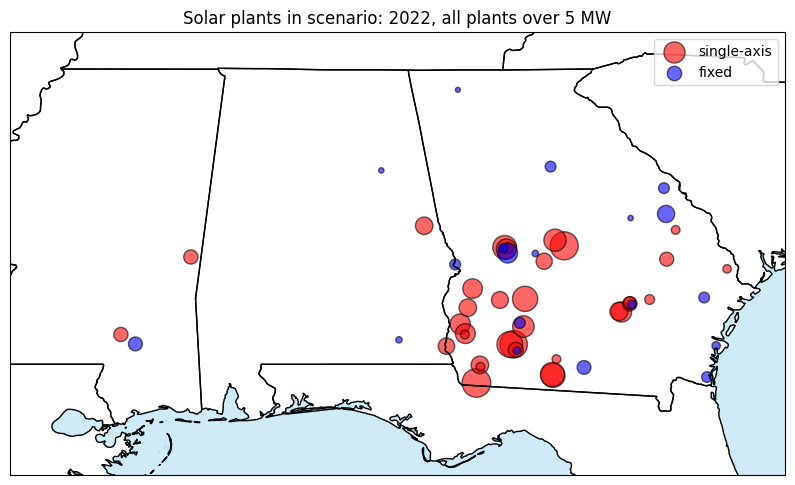

In [13]:
# 2022, plants greater than 5 MW
scenario_name = '2022, all plants over 5 MW'
year = 2022
interval = 5
output_folder = 'output/'
output_filename = 'actual_and_clearsky_solar_2022.csv'

plants_df = pd.read_csv('pv_fleet_metadata_rev3b.csv')
plants_df = plants_df[plants_df['power_plant_ac_max']>=5].copy().reset_index()
nsrdb_data_dict, nsrdb_metadata_dict = get_nsrdb_data(plants_df, email, nrel_api_key, year, interval)
result = make_profiles(plants_df=plants_df, nsrdb_data_dict=nsrdb_data_dict)
result.to_csv(output_folder + output_filename)
make_map(plants_df, scenario_name)

loaded NSRDB data from pickle file
calculated solar position
modeled actual power
modeled clear sky power


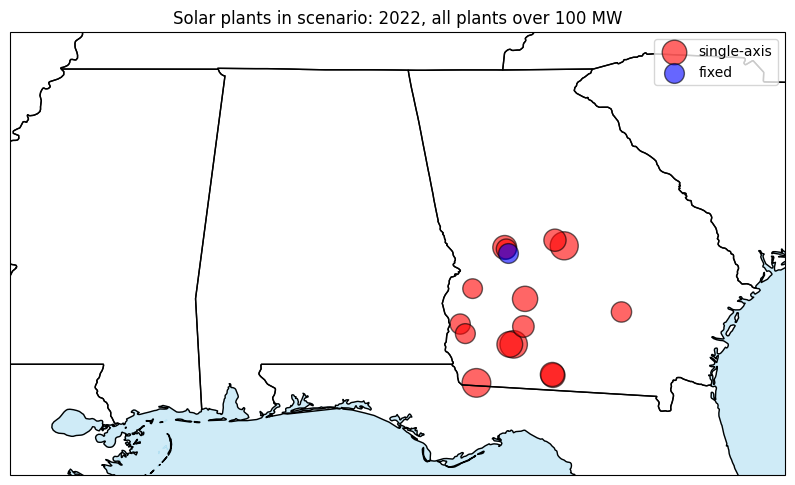

In [14]:
# 2022, plants greater than 100 MW
scenario_name = '2022, all plants over 100 MW'
year = 2022
interval = 5
output_folder = 'output/'
output_filename = 'actual_and_clearsky_solar_2022_large_plants.csv'

plants_df = pd.read_csv('pv_fleet_metadata_rev3b.csv')
plants_df = plants_df[plants_df['power_plant_ac_max']>=100].copy().reset_index() # <-- updated filter
nsrdb_data_dict, nsrdb_metadata_dict = get_nsrdb_data(plants_df, email, nrel_api_key, year, interval)
result = make_profiles(plants_df=plants_df, nsrdb_data_dict=nsrdb_data_dict)
result.to_csv(output_folder + output_filename)
make_map(plants_df, scenario_name)